In [5]:
import json 
import os 
import re
import glob
import pandas as pd
from collections import defaultdict
import javalang


In [6]:
import javalang 
from spiral.simple_splitters import delimiter_split

def get_continuous_code_snippets(desc_text_lines):
    snippets = []
    parsable_snippets = []
    cur_snippet = ''
    for l in desc_text_lines:
        if l[1] == 'CODE' and len(l[0].strip()) > 0:
            cur_snippet += l[0] + '\n'
        else:
            if len(cur_snippet.strip()) > 0:
                snippets.append(cur_snippet)
            cur_snippet = ''
    
    if len(cur_snippet.strip()) > 0:
        snippets.append(cur_snippet)
        
    assert '' not in snippets
    
    for s in snippets:
        if len(s.strip()) == 0:
            continue
        
        try:
            tree = javalang.parse.parse(s)
        except:
            continue
        if isinstance(tree, javalang.tree.MethodDeclaration) or isinstance(tree, javalang.tree.CompilationUnit):
            parsable_snippets.append(s)
            
    
    return snippets, parsable_snippets


def split(string):
    tokens = []
    for tok in re.split('\s|\(|\)', string):
        if len(tok.strip()) == 0:
            continue
        for tok2 in delimiter_split(tok):
            if len(tok2.strip()) == 0:
                continue
            if tok2 in ['{', '}', ';']:
                continue
            tokens.append(tok2)
    return tokens

def calc_similarity(gen_test, snippet):
    gen_test_tokens = set(split(gen_test))
    snippet_tokens = set(split(snippet))
    bi_sim = len(gen_test_tokens.intersection(snippet_tokens)) / (len(gen_test_tokens) + len(snippet_tokens))
    uni_sim = len(gen_test_tokens.intersection(snippet_tokens)) / (len(gen_test_tokens))
    
    return bi_sim, uni_sim

In [29]:
target_models = ['Codex', 'gpt-3.5-turbo-0301', 'gpt-3.5-turbo-0613', 'StarCoder', 'Incoder-6B', 'CodeGen2-16B']
success_bug_ids_by_model = {}
N = 10

for model in target_models:
    exec_res_data = json.load(open(f'../results/d4j_{model}.json')) # FIXME
    gen_test_path = f'../data/Defects4J/gen_tests/{model}/' # FIXME

    success_bug_ids = defaultdict(list)

    for bug_id, data in exec_res_data.items():
        for gen_test in data:
            if model == 'Codex':
                if int(gen_test.replace('.txt', '').split('_')[-1].removeprefix('n')) >= N:
                    continue
            elif int(gen_test.replace('.txt', '').split('_')[-1].removeprefix('n')) > N:
                continue
            
            res = data[gen_test]
            if isinstance(res, str):
                continue
            elif res['buggy']['compile_error'] or res['fixed']['compile_error']:
                continue
            elif res['buggy']['runtime_error'] or res['fixed']['runtime_error']:
                continue
            buggy_version_failing = False
            fixed_version_failing = False
            if res['buggy']['autogen_failed']:
                buggy_version_failing = True
            if res['fixed']['autogen_failed']:
                fixed_version_failing = True
            if buggy_version_failing and (not fixed_version_failing):
                success_bug_ids[bug_id].append(gen_test)

    success_bug_ids_by_model[model] = success_bug_ids
    

In [60]:
# How many of the 251 bug reports, for which LIBRO succeeded, provided partially or fully executable test code?

with open('../data/Defects4J/bug_report_features.json') as f:
    bug_report_features = json.load(f)
    

rows = []

bug_id_snippet_map = {}
bug_id_gentest_map = {}


for model in target_models:
    partial_code_elems_old = 0
    partial_code_elems = 0
    full_code_elems = 0
    bug_id_snippet_map[model] = {}
    bug_id_gentest_map[model] = {}

    success_bug_ids = success_bug_ids_by_model[model]
    gen_test_path = f'../data/Defects4J/gen_tests/{model}/'

    for bug_id, gen_tests in success_bug_ids.items():
        bug_id = bug_id.replace('_', '-')
        has_code = False
        has_full_code = False
        bug_report_text = json.load(open(f'../data/Defects4J/bug_report/{bug_id}.json'))['description'] # FIXME
        
        m = re.search(r'\<pre\>(.+)\<\/pre\>', bug_report_text)
        
        if len([l for l in bug_report_features[bug_id]['code_elements'] if len(l.strip()) > 0]) > 0:
            partial_code_elems_old += 1
        
        code_snippets, parsable_snippets = get_continuous_code_snippets(bug_report_features[bug_id]['desc_text'])
        if len(code_snippets) > 0:
            partial_code_elems += 1  
            has_code = True
        elif m is not None:
            partial_code_elems += 1
            has_code = True
            
        if len(parsable_snippets) > 0:
    #         print(parsable_snippets)
            full_code_elems += 1
            has_full_code = True
            
        # calculate similarity between LIBRO tests and test snippets in the bug report 
        
        max_similarity_uni = 0.0
        max_sim_test_uni = None
        for gen_test_name in gen_tests:
            with open(os.path.join(gen_test_path, gen_test_name)) as f:
                gen_test = f.read()
                for snp in parsable_snippets:
                    bi_sim, uni_sim = calc_similarity(gen_test, snp)
                    if uni_sim >= max_similarity_uni:
                        max_similarity_uni = uni_sim
                        max_sim_test_uni = gen_test_name
                        bug_id_snippet_map[model][bug_id] = snp
                        bug_id_gentest_map[model][bug_id] = gen_test

        rows.append({
            'model': model,
            'bug_id': bug_id,
            'project': bug_id.split('-')[0],
            'has_code': has_code,
            'has_full_code': has_full_code,
            'no_code': not has_code,
            'code_snippet_sim_uni': max_similarity_uni,
            'most_similar_gentest_uni': max_sim_test_uni,
        })
            
    total = len(success_bug_ids)

    print(f'\n[{model}]')
    print('# of success_bug_ids: ', total)
    print('# of full code snippets: ', full_code_elems)
    print('partial code snippets: ', partial_code_elems-full_code_elems, round((partial_code_elems - full_code_elems)/total*100, 2))
    print('full code snippets: ', full_code_elems, round(full_code_elems/total*100, 2))
    print('no code snippets: ', total - partial_code_elems, round((total - partial_code_elems)/total*100, 2))


[Codex]
# of success_bug_ids:  174
# of full code snippets:  32
partial code snippets:  83 47.7
full code snippets:  32 18.39
no code snippets:  59 33.91

[gpt-3.5-turbo-0301]
# of success_bug_ids:  166
# of full code snippets:  18
partial code snippets:  93 56.02
full code snippets:  18 10.84
no code snippets:  55 33.13

[gpt-3.5-turbo-0613]
# of success_bug_ids:  71
# of full code snippets:  4
partial code snippets:  38 53.52
full code snippets:  4 5.63
no code snippets:  29 40.85

[StarCoder]
# of success_bug_ids:  124
# of full code snippets:  22
partial code snippets:  70 56.45
full code snippets:  22 17.74
no code snippets:  32 25.81

[Incoder-6B]
# of success_bug_ids:  46
# of full code snippets:  3
partial code snippets:  30 65.22
full code snippets:  3 6.52
no code snippets:  13 28.26

[CodeGen2-16B]
# of success_bug_ids:  78
# of full code snippets:  13
partial code snippets:  43 55.13
full code snippets:  13 16.67
no code snippets:  22 28.21


In [63]:
for bug_id in bug_id_snippet_map['gpt-3.5-turbo-0613']:
    print(f'[{bug_id}]')
    print(bug_id_snippet_map['gpt-3.5-turbo-0613'][bug_id])
    print(bug_id_gentest_map['gpt-3.5-turbo-0613'][bug_id])
    print('------------------')

[Lang-24]
// not allowing L with an exponent


public void testNumberUtils() {
    assertFalse(NumberUtils.isNumber("1.1L"));
}

------------------
[Closure-114]
// ==ClosureCompiler==
// @output_file_name default.js
// @compilation_level ADVANCED_OPTIMIZATIONS
// ==/ClosureCompiler==


public void testIssueCrashOnWebClosureCompiler() {
    String jsCode = "var g=function(m){return m*Math.random()|0},d=document,h=d.getElementById('h'),c=d.getElementById('c'),l;(l=function(){requestAnimationFrame(l);h.style.textShadow=\"0 0 1px #000,\"+(g(10)-5)+\"px \"+(g(10)-5)+\"px 0 #888,0 0 180px rgb(\"+g(255)+\",\"+g(255)+\",\"+g(255)+\")\"})();d.addEventListener('mousemove',function(v){c.style.marginTop=(v.pageY/10+15|0)+'px'})";
    try {
        CompilerOptions options = new CompilerOptions();
        CompilationLevel.ADVANCED_OPTIMIZATIONS.setOptionsForCompilationLevel(options);
        Compiler compiler = new Compiler();
        compiler.disableThreads();
        Result result = compiler.comp

In [64]:
for bug_id in bug_id_snippet_map['gpt-3.5-turbo-0301']:
    print(f'[{bug_id}]')
    print(bug_id_snippet_map['gpt-3.5-turbo-0301'][bug_id])
    print(bug_id_gentest_map['gpt-3.5-turbo-0301'][bug_id])
    print('------------------')

[Math-79]
package org.fao.fisheries.chronicles.calcuation.cluster;
import static org.junit.Assert.assertEquals;
import static org.junit.Assert.assertTrue;
import java.util.Arrays;
import java.util.List;
import java.util.Random;
import org.apache.commons.math.stat.clustering.Cluster;
import org.apache.commons.math.stat.clustering.EuclideanIntegerPoint;
import org.apache.commons.math.stat.clustering.KMeansPlusPlusClusterer;
import org.fao.fisheries.chronicles.input.CsvImportProcess;
import org.fao.fisheries.chronicles.input.Top200Csv;
import org.junit.Test;
public class ClusterAnalysisTest {
@Test
public void testPerformClusterAnalysis2() {
KMeansPlusPlusClusterer<EuclideanIntegerPoint> transformer = new KMeansPlusPlusClusterer<EuclideanIntegerPoint>(
new Random(1746432956321l));
EuclideanIntegerPoint[] points = new EuclideanIntegerPoint[] {
new EuclideanIntegerPoint(new int[]
{ 1959, 325100 }
),
new EuclideanIntegerPoint(new int[]
{ 1960, 373200 }
), };
List<Cluster<EuclideanIntegerPoin

<Axes: title={'center': 'code_snippet_sim_uni'}, xlabel='model'>

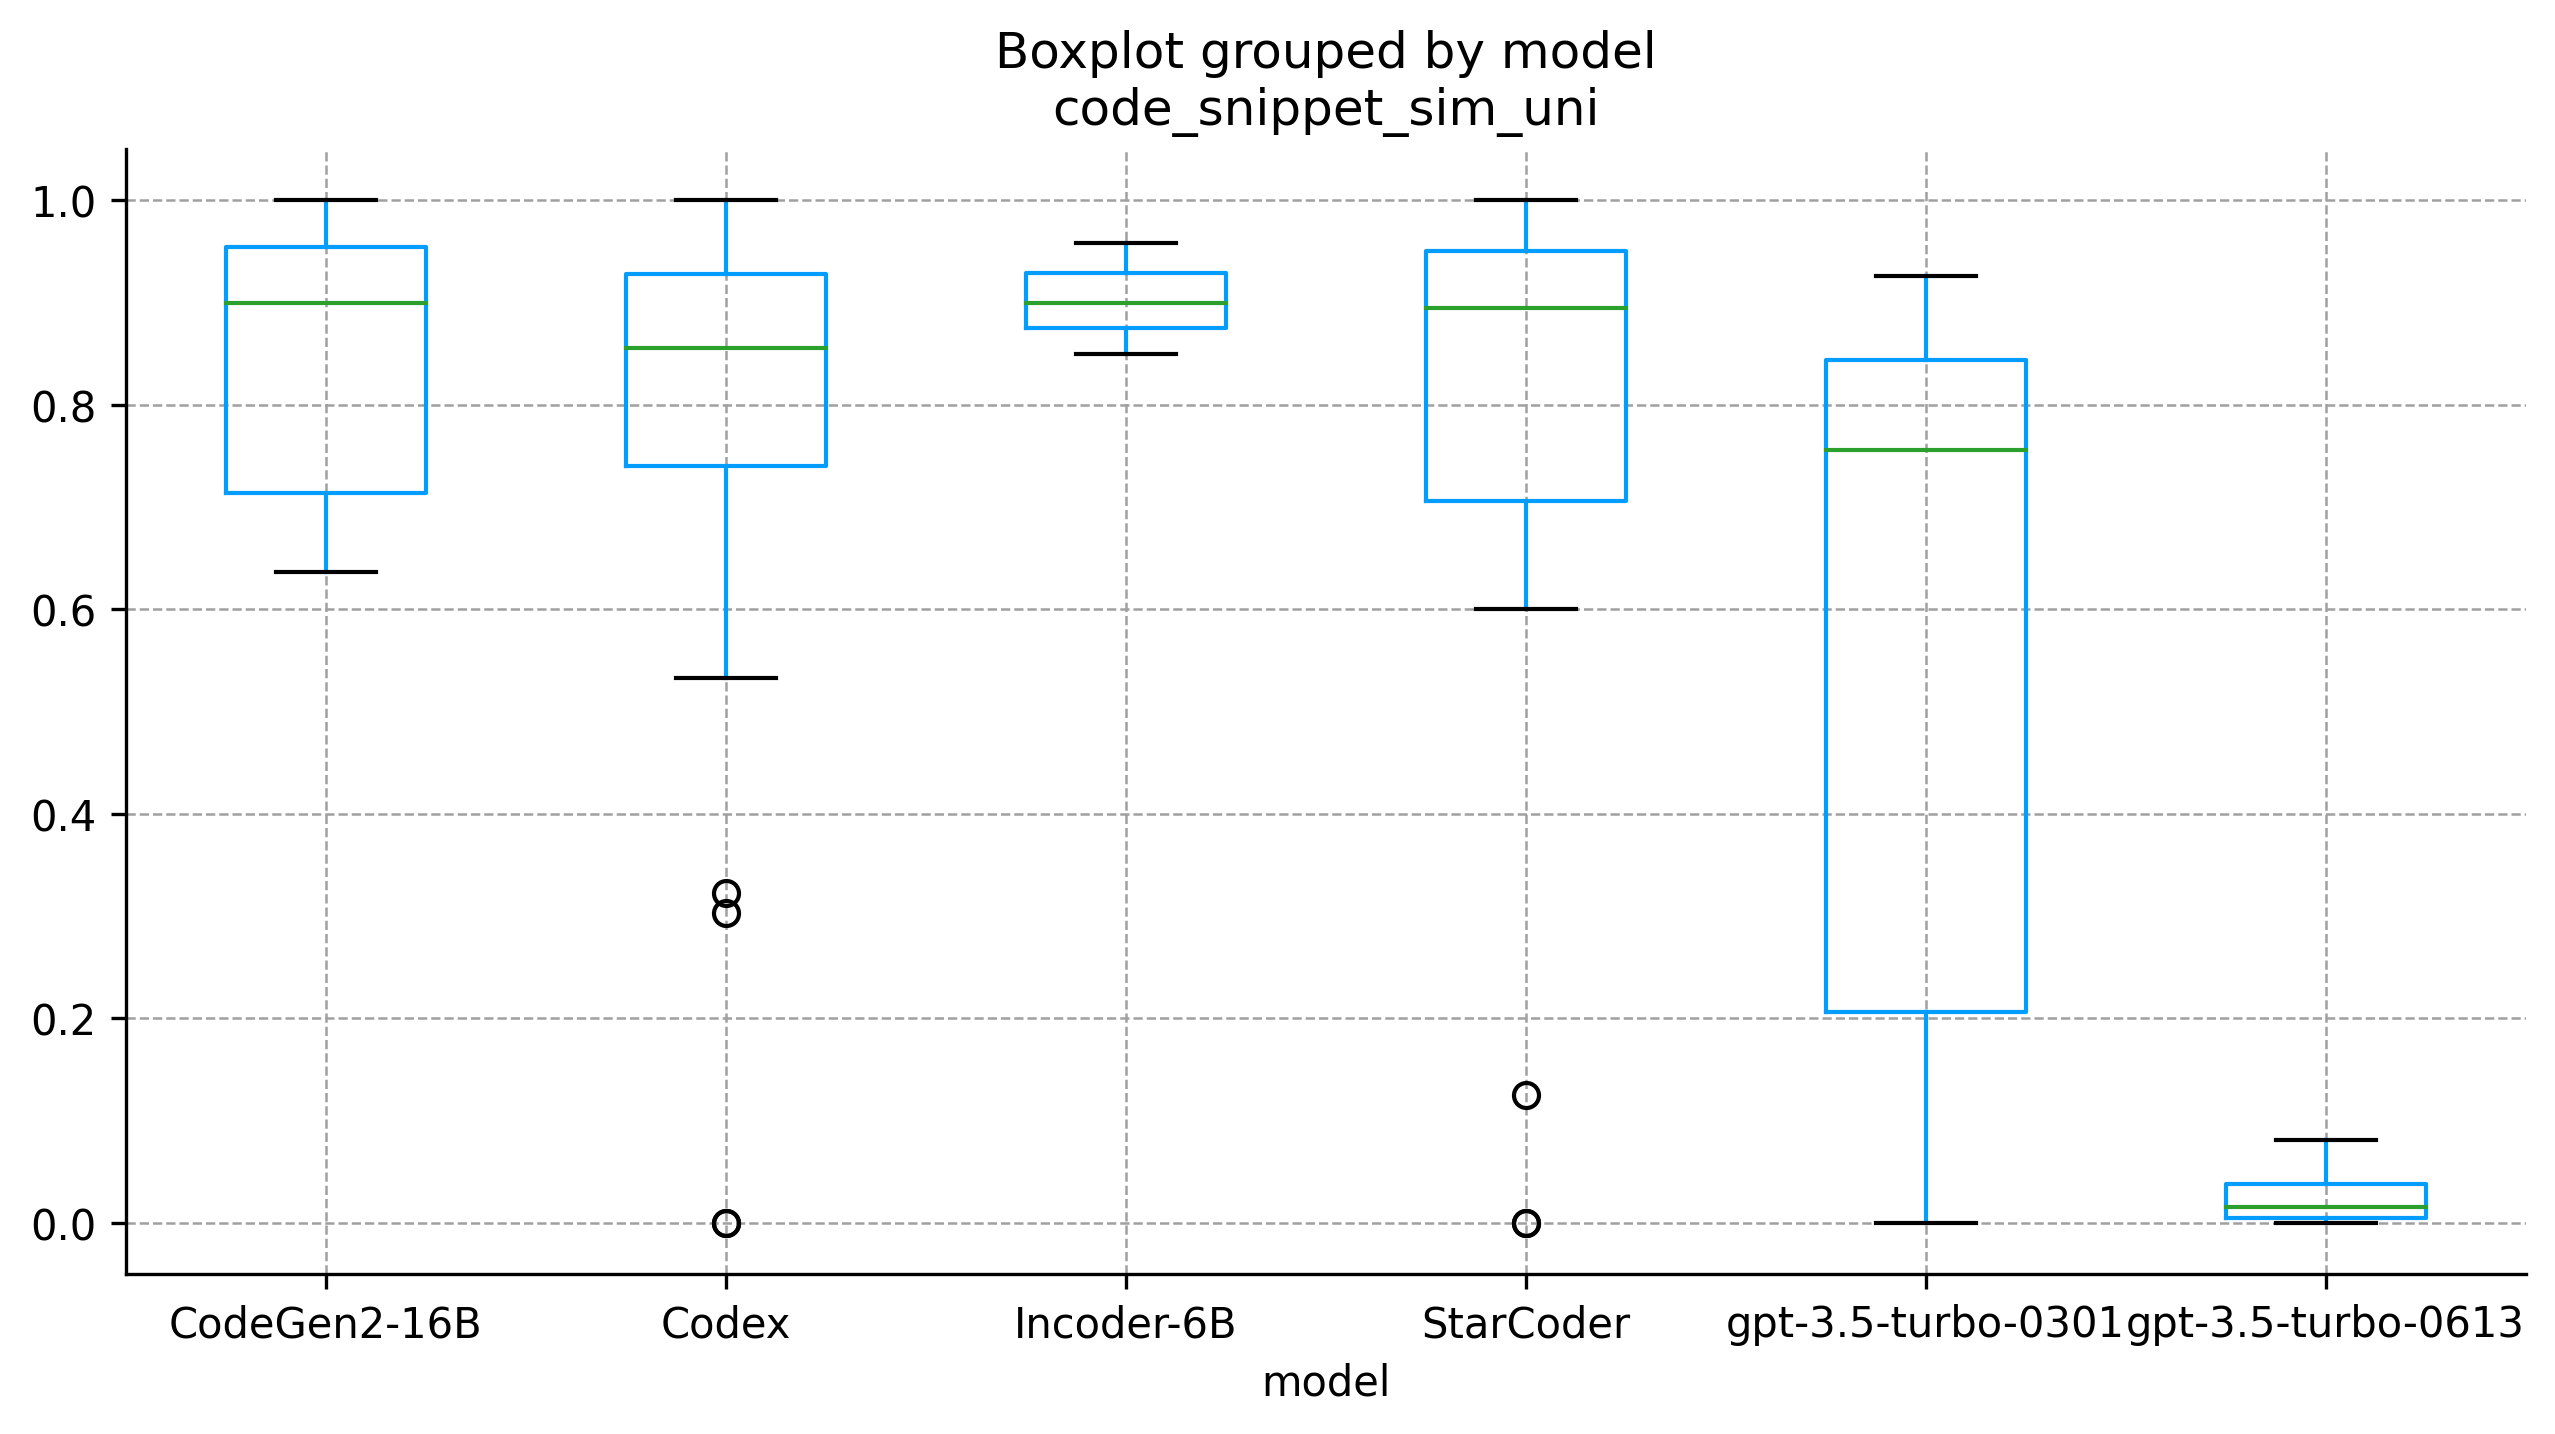

In [67]:
df = pd.DataFrame(rows)
df = df[~df['most_similar_gentest_uni'].isnull()]
df.boxplot(column=['code_snippet_sim_uni'], by='model', figsize=(10, 5))

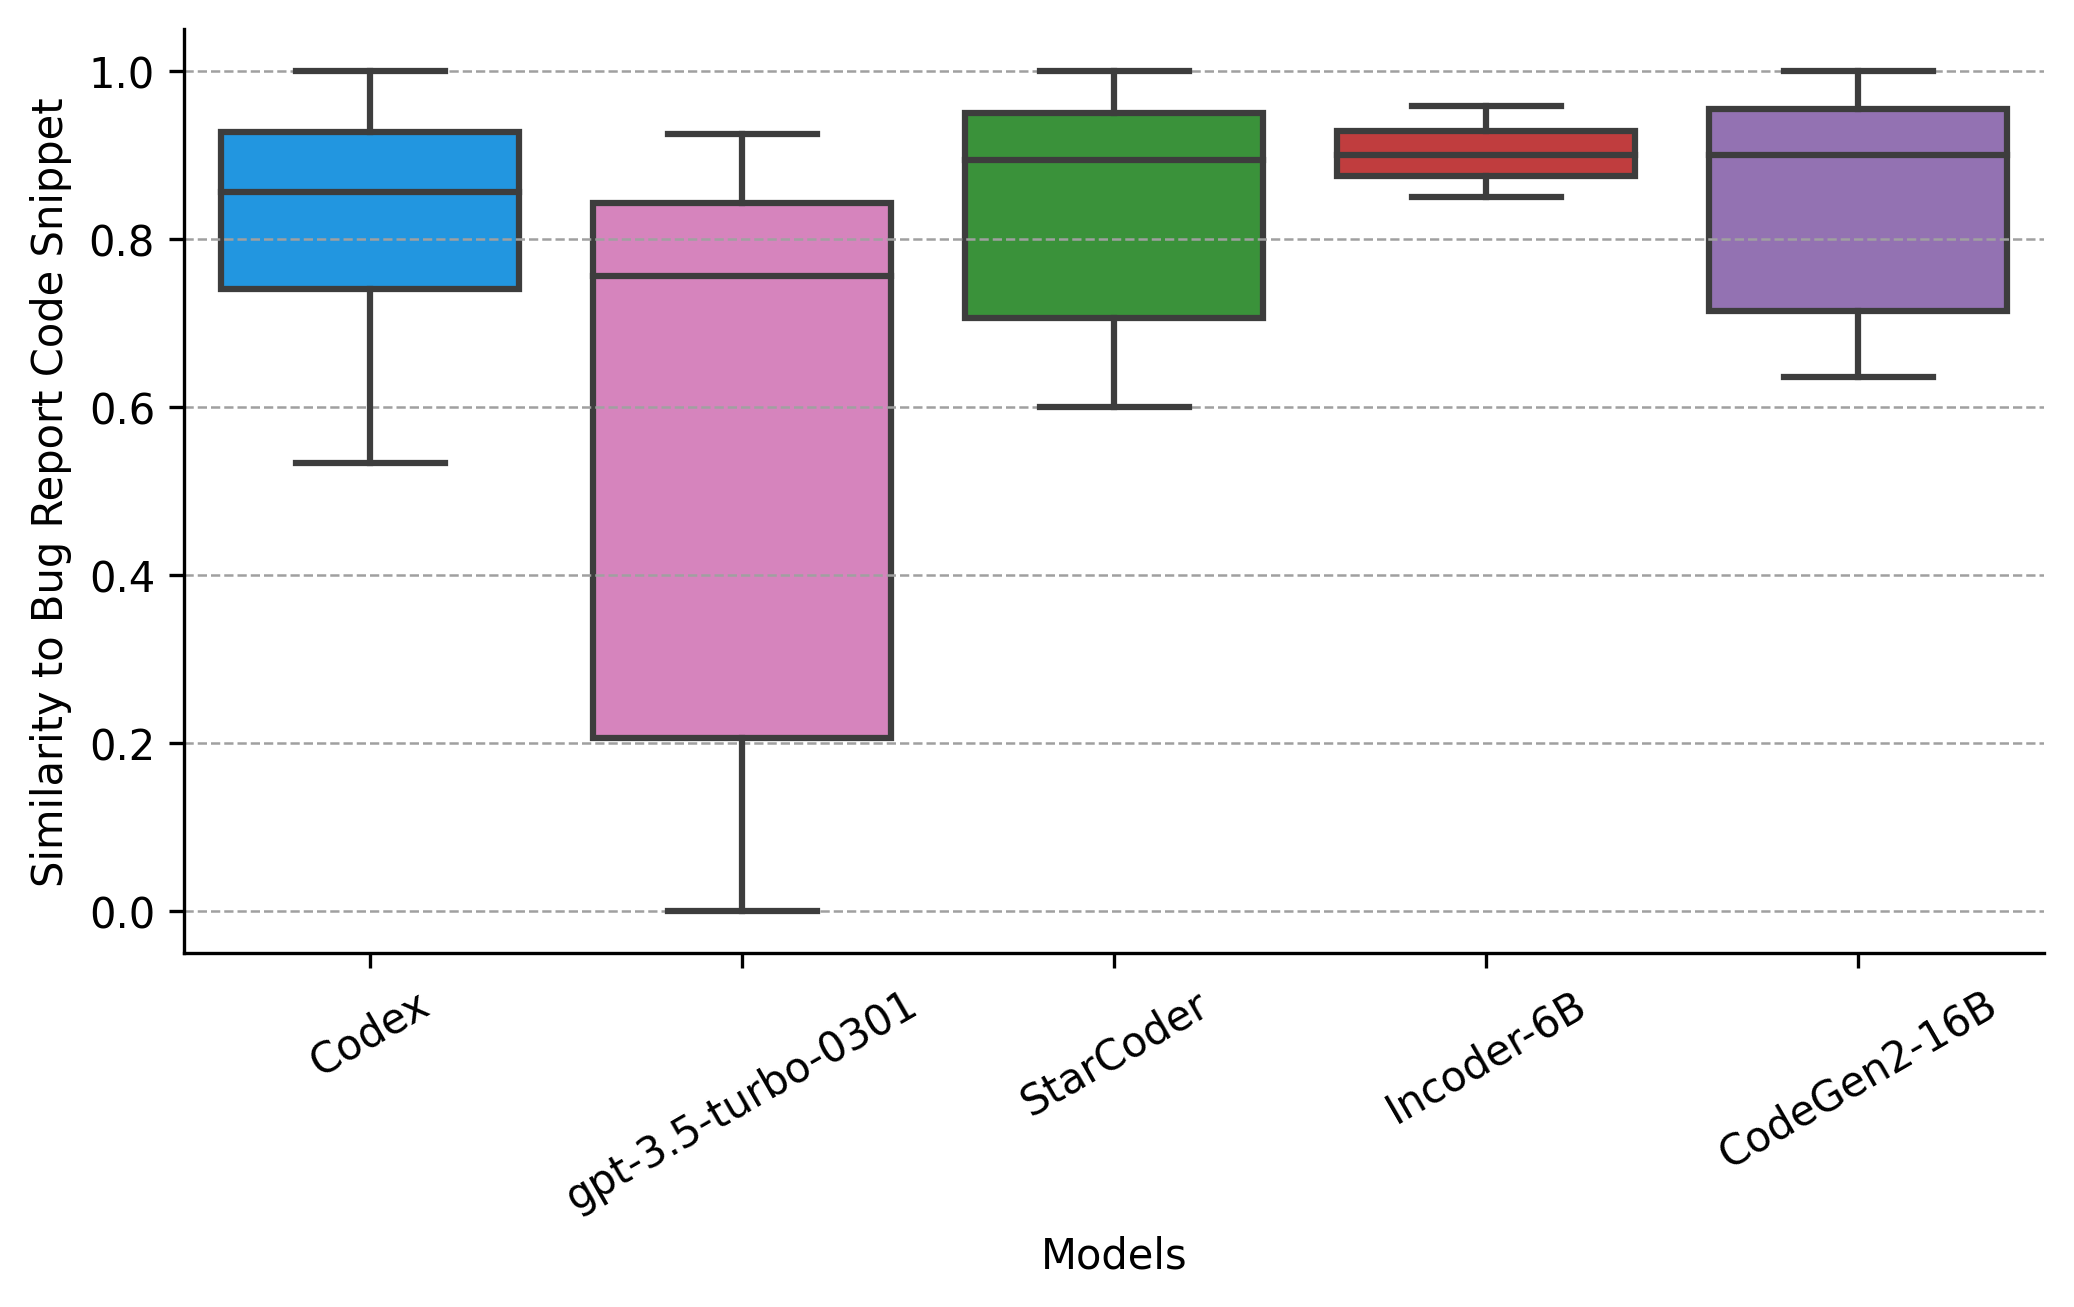

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('./smstyle-formal.mplstyle')

fig, ax = plt.subplots(figsize=(8, 4))

df = df[df.model != 'gpt-3.5-turbo-0613']
df.rename(columns={'code_snippet_sim_uni': 'Similarity to Bug Report Code Snippet', 'model': 'Models'}, inplace=True)
sns.boxplot(data=df, x='Models', y='Similarity to Bug Report Code Snippet', ax=ax, showfliers=False)

# rotate x tick labels
for tick in ax.get_xticklabels():
    tick.set_rotation(30)

plt.savefig('../data/figures/bug_report_code_snippet_similarity.pdf', bbox_inches='tight')